In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

%matplotlib inline

from mood_classification import MOODS_AND_LYRICS_PICKLE
from utils import unpicklify

# Predictions Dumped During Model Training

We figured out how to dump predictions by evaluating the predictions tensor as part of the call to session.run. The tensor returned the predicted mood for each input. We then created a confusion matrix with tf.confusion_matrix and saved it to a file. Here, we explore those saved matrices.

In [2]:
datasrc = MOODS_AND_LYRICS_PICKLE
datasrc = datasrc.replace('mood_classification', 'mood_classification_quadrants')
data = unpicklify(datasrc)

In [3]:
# https://stackoverflow.com/questions/30510562/get-mapping-of-categorical-variables-in-pandas
mood_map = {str(key): value for key, value in dict(enumerate(data.mood.cat.categories)).items()}
moods_ordered = [mood_map[str(i)] for i in range(len(mood_map))]
print(mood_map)
print(moods_ordered)

{'1': 'calm', '3': 'sad', '2': 'happy', '0': 'anger'}
['anger', 'calm', 'happy', 'sad']


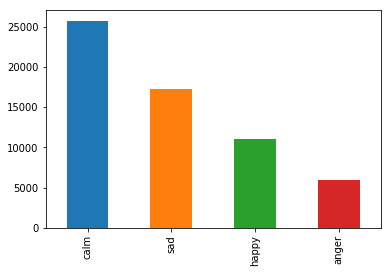

In [4]:
_ = data.mood.value_counts().plot(kind='bar')

In [45]:
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
#for conf_csv in conf_matrices:
def display_conf_matrix(df_cm):
    plt.figure(figsize=(15,12))
    #sn.set(font_scale=1.4)#for label size
    # https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
    _ = sn.heatmap(
            df_cm,
            annot=True,
            fmt='g',
            annot_kws={"size": 16},
            cmap=sn.cm.rocket_r)

def display_mood_pcts(df_cm):
    moods_ordered = [mood_map[str(i)] for i in range(len(mood_map))]
    incorrect = dict()
    for i, (index, row) in enumerate(df_cm.iteritems()):
        incorrect[index] = row.sum() - row[i]
    for i, (index, row) in enumerate(df_cm.transpose().iteritems()):
        total = row.sum()
        correct = row[i]
        pct = correct / total * 100
        print('{0}: total={1}, correct={2}, pct={3:.02f}%, incorrect={4}'.format(
            mood_map[str(i)], total, correct, pct, incorrect[mood_map[str(i)]]))

In [48]:
conf_matrices = [
    'logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.75_L2-0.01_B-128_Ep-12_W2V-1_V-49999/300_confusion.csv',
    'logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.75_L2-0.01_B-128_Ep-12_W2V-1_V-49999/3100_confusion.csv',
    'logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.75_L2-0.01_B-128_Ep-12_W2V-1_V-49999/3600_confusion.csv',
    'logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.75_L2-0.01_B-128_Ep-11_W2V-1_V-49999/2640_confusion.csv',
    'logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.75_L2-0.01_B-128_Ep-11_W2V-1_V-49999_mood-quadrants/3091_confusion.csv'
]

anger: total=1191, correct=398, pct=33.42%, incorrect=105
calm: total=5151, correct=3616, pct=70.20%, incorrect=2317
happy: total=2212, correct=1291, pct=58.36%, incorrect=1278
sad: total=3429, correct=1798, pct=52.44%, incorrect=1180


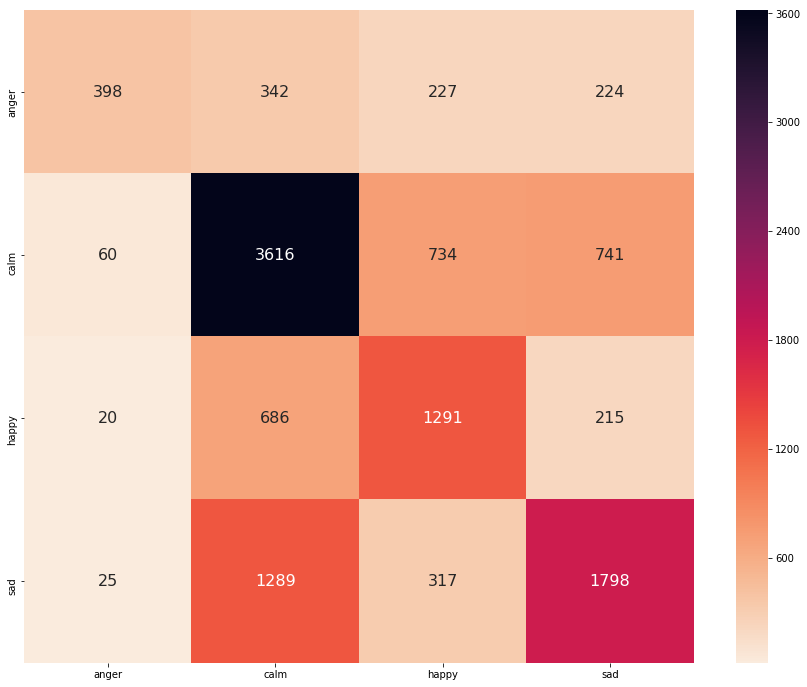

In [49]:
df_cm = pd.read_csv(conf_matrices[4])
# in case we saved csv with the index
if 'Unnamed: 0' in df_cm.columns:
    df_cm = df_cm.drop('Unnamed: 0', axis=1)
    df_cm = df_cm.rename(columns=mood_map)
    df_cm.index = moods_ordered

display_conf_matrix(df_cm)
display_mood_pcts(df_cm)

# Attempt to Restore and Regenerate Predictions

https://www.tensorflow.org/guide/saved_model

In [31]:
import tensorflow as tf
import os

tf.reset_default_graph()  
latest_ckp = 'logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.75_L2-0.01_B-64_Ep-12_W2V-1_V-50000/checkpoints/'
model_meta = "logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.75_L2-0.01_B-64_Ep-12_W2V-1_V-50000/checkpoints/model-7100.meta"
model_data = "logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.75_L2-0.01_B-64_Ep-12_W2V-1_V-50000/checkpoints/model-7100.data-00000-of-00001"
model_index = "logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.75_L2-0.01_B-64_Ep-12_W2V-1_V-50000/checkpoints/model-7100.index"
if os.path.exists(model_meta):
    imported_meta = tf.train.import_meta_graph(model_data)
    print('it is go time!')
graph = tf.Graph()
with graph.as_default():
    with tf.Session() as sess:  
        imported_meta.restore(sess, tf.train.latest_checkpoint(model_index))
        #h_est2 = sess.run('hor_estimate:0')
        #v_est2 = sess.run('ver_estimate:0')
        #print("h_est: %.2f, v_est: %.2f" % (h_est2, v_est2))

        # Placeholders for input, output and dropout
        input_x = graph.get_tensor_by_name('input_x:0')
        input_y = graph.get_tensor_by_name('input_y')
        dropout_keep_prob = graph.get_tensor_by_name('dropout_keep_prob')

        scores = graph.get_tensor_by_name("scores")
        predictions = graph.get_tensor_by_name("predictions")

        sess.run(prediction, feed_dict={
            batch_size_placeholder: some_value,
            features_placeholder: some_other_value,
            labels_placeholder: another_value
        })

        batch_size_placeholder = graph.get_tensor_by_name('batch_size_placeholder:0')
        features_placeholder = graph.get_tensor_by_name('features_placeholder:0')
        labels_placeholder = graph.get_tensor_by_name('labels_placeholder:0')
        prediction = restored_graph.get_tensor_by_name('dense/BiasAdd:0')

        self.input_x = tf.placeholder(tf.int32, [None, self.sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, self.num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        feed_dict = {
            self.input_x: x_batch,
            self.input_y: y_batch,
            self.dropout_keep_prob: self.dropout if train_op else 1.0
        }
        _, step, summaries, loss, accuracy = sess.run(
            [train_op, global_step, summary_op, self.loss, self.accuracy],
            feed_dict)

        step, summaries, loss, accuracy = sess.run(
            [global_step, summary_op, self.loss, self.accuracy],
            feed_dict)



FailedPreconditionError: logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.75_L2-0.01_B-64_Ep-12_W2V-1_V-50000/checkpoints; Is a directory

In [27]:
from tensorflow.python import pywrap_tensorflow
import os


checkpoint_path = model_index
# List ALL tensors example output: v0/Adam (DT_FLOAT) [3,3,1,80]
print_tensors_in_checkpoint_file(file_name=checkpoint_path, all_tensors=True, tensor_name='')

# List contents of v0 tensor.
# Example output: tensor_name:  v0 [[[[  9.27958265e-02   7.40226209e-02   4.52989563e-02   3.15700471e-02
print_tensors_in_checkpoint_file(file_name=checkpoint_path, all_tensors=True, tensor_name='v0')

# List contents of v1 tensor.
print_tensors_in_checkpoint_file(file_name=checkpoint_path, all_tensors=True, tensor_name='v1')

reader = pywrap_tensorflow.NewCheckpointReader(model_index)
var_to_shape_map = reader.get_variable_to_shape_map()

for key in var_to_shape_map:
    print("tensor_name: ", key)
    print(reader.get_tensor(key)) # Remove this is you want to print only variable names